In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# shap
import shap

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Run VS Pass based on pre-snap indicators

The goal of this notebook is to build a model that can predict whether a play is a run or a pass based on pre-snap indicators. the dataset is apart of the NFL Big Data Bowl 2025. 

- plays.csv: contains play-by-play data for each game
- player_play.csv: contains player-by-play data for each game
- games.csv: contains game-by-game data for each game
- motion_features.csv: contains motion features for each play
- players.csv: contains player data for each player

The notebook will go through cleaning and preprocessing of the data, feature engineering, and building a "Soft-order" 2D CNN model to make predictions. The model will be trained on a 80/20 split and will use cross-entropy loss.

the only post snap feature will be the isDropback feature. which is 1 if the play is a pass and 0 if it is a run.

In [2]:
plays_df = pd.read_csv('./data/plays.csv')
player_play_df = pd.read_csv('./data/player_play.csv')
games_df = pd.read_csv('./data/games.csv')

# check the data

In [3]:
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [4]:
print(plays_df['playDescription'][0])
print("drop",len(plays_df[plays_df['qbKneel'] == 1]), "qb kneels")
plays_df = plays_df[plays_df['qbKneel'] == 0]
plays_df.head()

(1:54) (Shotgun) J.Burrow pass short middle to T.Boyd to CIN 30 for 9 yards (J.Hawkins).
drop 165 qb kneels


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [5]:
player_play_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


## Merge the datasets

Combine the datasets into one based on the gameId column, and perform data cleaning and feature engineering. This will be the dataset that will be used for modeling.

In [7]:
def merge_dataset(plays_df, games_df):
    """
    Combine 2 datasets into one based on the gameId column, and perform
    data cleaning and feature engineering.
    """
    df = plays_df.merge(games_df, on='gameId', how='left')
    
    df['is_pass'] = df['isDropback'].astype(int)
    df['is_home_team'] = df['possessionTeam'] == df['homeTeamAbbr']
    
    df['score_differential'] = np.where(
        df['is_home_team'],
        df['preSnapHomeScore'] - df['preSnapVisitorScore'],
        df['preSnapVisitorScore'] - df['preSnapHomeScore']
    )
    
    print(f"Data set length: {len(df)}")
    print(df.info())
    
    return df

In [8]:
df = merge_dataset(plays_df, games_df)

Data set length: 15959
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15959 entries, 0 to 15958
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            15959 non-null  int64  
 1   playId                            15959 non-null  int64  
 2   playDescription                   15959 non-null  object 
 3   quarter                           15959 non-null  int64  
 4   down                              15959 non-null  int64  
 5   yardsToGo                         15959 non-null  int64  
 6   possessionTeam                    15959 non-null  object 
 7   defensiveTeam                     15959 non-null  object 
 8   yardlineSide                      15740 non-null  object 
 9   yardlineNumber                    15959 non-null  int64  
 10  gameClock                         15959 non-null  object 
 11  preSnapHomeScore                  15959 non-

## Check the run/pass distribution

The distribution is skewed towards run plays. This is expected as the NFL has made more of a transition to pass heavy offenses in the recent years.

with 61% of the plays being pass plays and 39% being run plays. The classses are imbalanced, but not severely.


Run/Pass Distribution:
is_pass
1    0.610063
0    0.389937
Name: proportion, dtype: float64


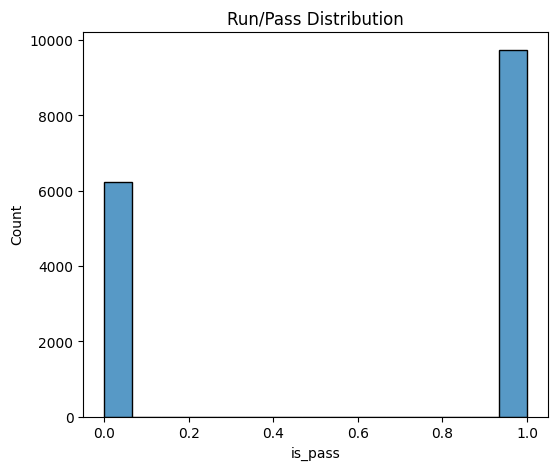

In [9]:
print("\nRun/Pass Distribution:")
print(df['is_pass'].value_counts(normalize=True))
plt.figure(figsize=(6, 5))
sns.histplot(df, x='is_pass', multiple='stack')
plt.title('Run/Pass Distribution')
plt.show()

## Create motion features

Create more granular motion features based on the motion_features.csv file. This will be used to train the CNN.


### Motion features
A few notable features related to motion in the motion_features.csv file create from the tracking data the competition provided.

- The **s** value represents the count of frames where a player had significant movement (speed > 0.62) in the last 10 frames before the snap. Since there are 10 frames total, s would range from 0-10.
- The **x** value represents the total distance moved by all players in the play. i.e the sum of the absolute difference in the x and y coordinates of each player. A motion level of 0 would be no motion, and a motion level of 3 would be the most motion.
- The **motion_intensity** is the **x** value divided by the **s** value. This is a measure of how much motion there is per frame. A motion intensity of 0 would be no motion, and a motion intensity of 3 would be the most motion.

In [10]:
# get combined tracking weeks csv
motion_features = pd.read_csv('./data/motion_features.csv') 
valid_plays = plays_df[['gameId', 'playId']].copy()
all_motion = []

# motion features
motion_features['motion_frames'] = motion_features['s']  # Raw count of motion frames
motion_features['total_movement'] = motion_features['x']  # Raw movement distance

# numerical motion levels (0-3)
motion_features['motion_level'] = pd.cut(motion_features['s'],
                                       bins=[-float('inf'), 0, 3, 6, float('inf')],
                                       labels=[0, 1, 2, 3]).astype(float)

# motion intensity (movement per frame with motion)
motion_features['motion_intensity'] = motion_features['x'] / motion_features['s'].clip(lower=1)

# binary flags with thresholds
motion_features['has_motion'] = (motion_features['s'] >= 2).astype(float)
motion_features['significant_movement'] = (motion_features['x'] > 1.5).astype(float)
motion_features['high_intensity'] = (motion_features['motion_intensity'] > 0.3).astype(float)

# Merge with valid plays
final_motion = motion_features.merge(valid_plays, on=['gameId', 'playId'], how='right')

print(f"Total plays processed: {len(final_motion)}")
print(f"Plays with motion: {final_motion['has_motion'].sum()}")
print(f"Plays with significant movement: {final_motion['significant_movement'].sum()}")
print(f"Plays with high intensity motion: {final_motion['high_intensity'].sum()}")
print(final_motion['motion_level'].value_counts(normalize=True))

Total plays processed: 15959
Plays with motion: 143.0
Plays with significant movement: 20.0
Plays with high intensity motion: 173.0
motion_level
0.0    0.770696
1.0    0.212878
2.0    0.011827
3.0    0.004599
Name: proportion, dtype: float64


In [11]:
# merge with original features
final_motion = final_motion.fillna(0)
print(final_motion.columns)
df = df.merge(final_motion[['gameId', 'playId', 'has_motion', 'significant_movement', 'motion_level', 'motion_frames', 'total_movement', 'motion_intensity', 'playDirection']], 
                                    on=['gameId', 'playId'])

Index(['Unnamed: 0', 'gameId', 'playId', 's', 'x', 'playDirection',
       'motion_frames', 'total_movement', 'motion_level', 'motion_intensity',
       'has_motion', 'significant_movement', 'high_intensity'],
      dtype='object')



Motion Statistics by Play Type:
         has_motion  significant_movement  motion_intensity
is_pass                                                    
0          0.007231              0.001446          0.010285
1          0.010066              0.001130          0.010150


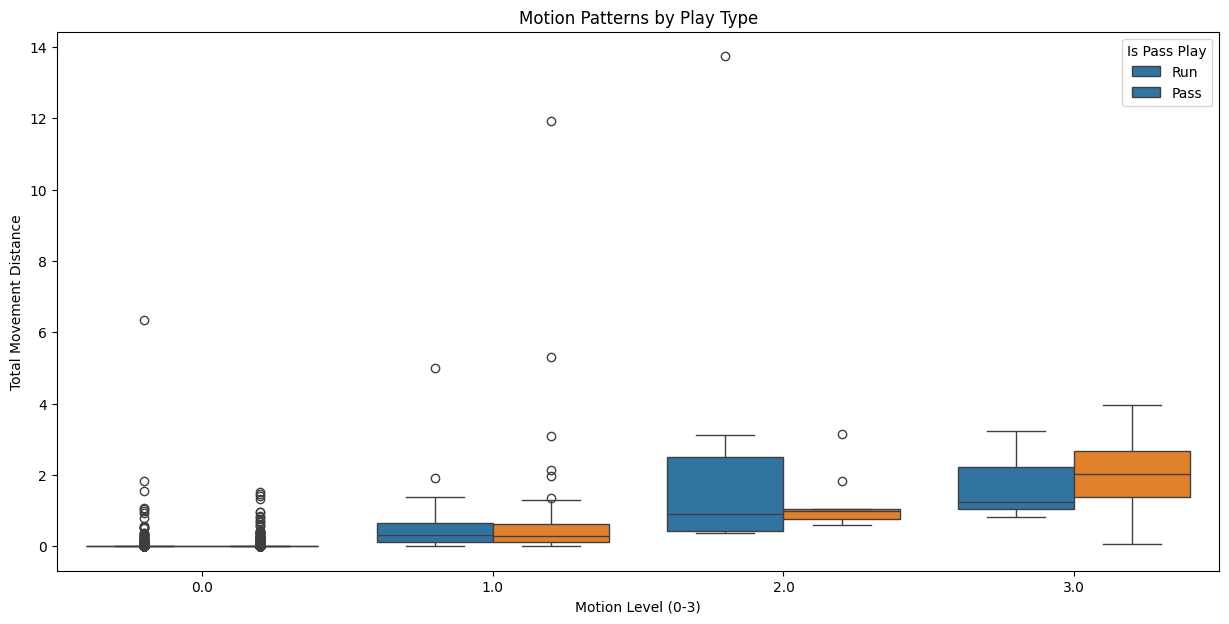

In [12]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df, x='motion_level', y='total_movement', hue='is_pass')
plt.title('Motion Patterns by Play Type')
plt.xlabel('Motion Level (0-3)')
plt.ylabel('Total Movement Distance')
plt.legend(title='Is Pass Play', labels=['Run', 'Pass'])

# Print some summary statistics
print("\nMotion Statistics by Play Type:")
print(df.groupby('is_pass')[['has_motion', 'significant_movement', 'motion_intensity']].mean())

## Create situational features

Create situational features related to down, distance, field position and time.

### situational features
Most features are binary indicators based on the situation of the play. except for the **yards_to_goal** feature which is the absolute yardline number of the ball.


In [13]:
def create_situational_features(df):
    """
    Create situational features related to down, distance, field position and time
    """
    feature_df = df.copy()
    feature_df = pd.get_dummies(feature_df, columns=['down'], prefix='down')
    
    # Distance situations
    feature_df['distance_short'] = feature_df['yardsToGo'] <= 3
    feature_df['distance_long'] = feature_df['yardsToGo'] >= 7
    feature_df['is_third_and_long'] = (feature_df['down_3'] == 1) & feature_df['distance_long']
    
     # Clean playDirection first
    feature_df['playDirection'] = feature_df['playDirection'].fillna('right')
    feature_df.loc[feature_df['playDirection'] == 0, 'playDirection'] = 'right'
    
    # Normalize yard line (0 = own goal line, 100 = opponent goal line)
    feature_df['yards_to_goal'] = np.where(
        feature_df['playDirection'] == 'right',
        100 - feature_df['absoluteYardlineNumber'],
        feature_df['absoluteYardlineNumber']
    )
    
    # Clip yards_to_goal to valid range
    feature_df['yards_to_goal'] = feature_df['yards_to_goal'].clip(0, 100)
    feature_df['in_redzone'] = feature_df['yards_to_goal'] <= 20
    feature_df['backed_up'] = feature_df['absoluteYardlineNumber'] <= 10
    
    # Convert game clock to seconds remaining in quarter
    feature_df['game_clock_seconds'] = feature_df['gameClock'].apply(
        lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])
    )
    
    # End of half situations (last 2 minutes)
    feature_df['end_of_half'] = (feature_df['quarter'].isin([2, 4])) & \
                               (feature_df['game_clock_seconds'] <= 120)
    
    # scoring situation features 
    feature_df['score_differential_bucket'] = pd.cut(
        feature_df['score_differential'],
        bins=[-28, -17, -9, -3, 3, 9, 17, 28],
        labels=['big_deficit', 'medium_deficit', 'small_deficit', 
                'close', 'small_lead', 'medium_lead', 'big_lead']
    )
    
    feature_df['time_remaining_half'] = feature_df.apply(lambda x: 
        1800 if x['quarter'] <= 2 else 3600 - x['game_clock_seconds'], axis=1)
    
     # One-hot encoded downs, week, quarter
    feature_df = pd.get_dummies(feature_df, columns=['quarter'], prefix='quarter')
    
    # Win probability features
    feature_df['win_prob_differential'] = feature_df['preSnapHomeTeamWinProbability'] - feature_df['preSnapVisitorTeamWinProbability']
    
    return feature_df

In [14]:
# Apply the features
df_with_features = create_situational_features(df)
situational_features = [col for col in df_with_features.columns if col not in df.columns]

In [15]:
# Quick validation
print("\nFeature Statistics:")
for feature in situational_features:
    if df_with_features[feature].dtype in ['int64', 'float64']:
        print(f"\n{feature}:")
        print(df_with_features[feature].describe())


Feature Statistics:

yards_to_goal:
count    15959.000000
mean        40.884705
std         24.358605
min          0.000000
25%         20.000000
50%         41.000000
75%         61.000000
max        100.000000
Name: yards_to_goal, dtype: float64

game_clock_seconds:
count    15959.000000
mean       434.034275
std        270.506272
min          1.000000
25%        188.000000
50%        425.000000
75%        669.000000
max        900.000000
Name: game_clock_seconds, dtype: float64

time_remaining_half:
count    15959.000000
mean      2483.257723
std        705.780634
min       1800.000000
25%       1800.000000
50%       2700.000000
75%       3175.000000
max       3599.000000
Name: time_remaining_half, dtype: float64

win_prob_differential:
count    15959.000000
mean         0.104717
std          0.577009
min         -0.997901
25%         -0.346827
50%          0.157877
75%          0.578964
max          0.998393
Name: win_prob_differential, dtype: float64


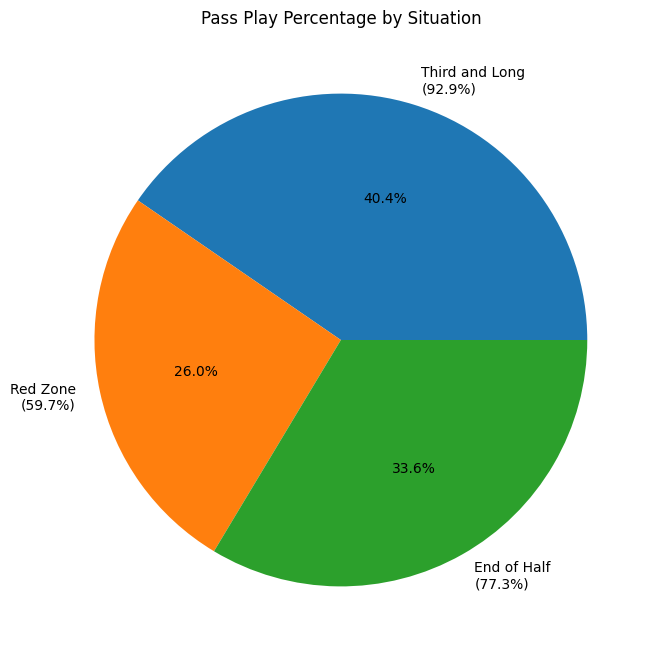

In [16]:
# Pass play percentage by situation
plt.figure(figsize=(10, 8))
situations = [
    ('is_third_and_long', 'Third and Long'),
    ('in_redzone', 'Red Zone'),
    ('end_of_half', 'End of Half'),
]
pass_pcts = []
labels = []
for col, label in situations:
    pass_pct = df_with_features[df_with_features[col]][['is_pass']].mean()['is_pass']
    pass_pcts.append(pass_pct)
    labels.append(f"{label}\n({pass_pct:.1%})")

plt.pie(pass_pcts, labels=labels, autopct='%1.1f%%')
plt.title('Pass Play Percentage by Situation')
plt.show()

## 1.6 Plotting Situational Features

The first subplot on the left shows the pass percentage by down. The second subplot shows the yards to go distribution by down and play type. with the pass plays in blue and the run plays in red.

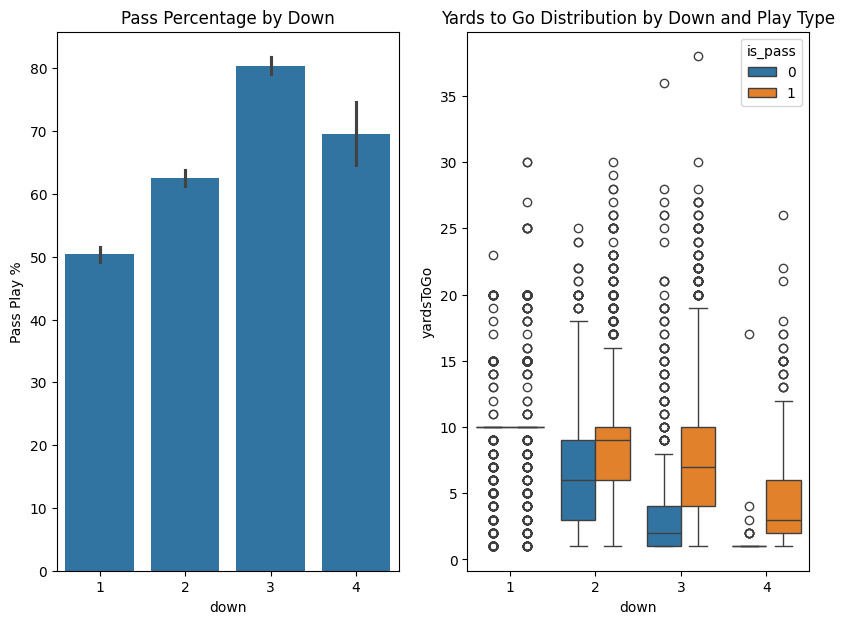

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(131)
sns.barplot(data=df, x='down', y='is_pass', 
            errorbar=('ci', 95), estimator=lambda x: sum(x)/len(x)*100)
plt.title('Pass Percentage by Down')
plt.ylabel('Pass Play %')

plt.subplot(132)
sns.boxplot(data=df, x='down', y='yardsToGo', hue='is_pass')
plt.title('Yards to Go Distribution by Down and Play Type')

plt.show()

## Formation Features

Formation features are created by encoding the formation into a binary indicator and then creating additional features based on the receiver alignment.

In [18]:
def create_formation_features(df):
    """
    Create features based on offensive formation and receiver alignment
    """
    feature_df = df.copy()
    feature_df['offenseFormation'] = feature_df['offenseFormation'].fillna('UNKNOWN')
    
    # One-hot encode base formation
    feature_df = pd.get_dummies(feature_df, columns=['offenseFormation'], prefix='formation')
    
    # Clean and process receiver alignment
    feature_df['receiverAlignment'] = feature_df['receiverAlignment'].fillna('0x0')
    
    # Extract receiver alignment (3x2 is 3 left 2 right)
    alignment_split = feature_df['receiverAlignment'].str.extract(r'(\d)x(\d)')
    feature_df['receivers_left'] = pd.to_numeric(alignment_split[0], errors='coerce').fillna(0)
    feature_df['receivers_right'] = pd.to_numeric(alignment_split[1], errors='coerce').fillna(0)
    
    # Total receivers wide
    feature_df['total_receivers_wide'] = feature_df['receivers_left'] + feature_df['receivers_right']
    
    # Balanced/Unbalanced formation
    feature_df['is_balanced'] = feature_df['receivers_left'] == feature_df['receivers_right']
    
    # Empty backfield (5 or more receivers wide, then backfield is empty)
    feature_df['is_empty'] = feature_df['total_receivers_wide'] >= 5
    
    # Shotgun vs Under Center (from playDescription)
    feature_df['is_no_huddle'] = feature_df['playDescription'].str.contains('No Huddle', case=False, na=False)
    
    # Heavy personnel (based on receiver count)
    feature_df['is_heavy_formation'] = feature_df['total_receivers_wide'] <= 2
    feature_df['is_light_formation'] = feature_df['total_receivers_wide'] >= 4
    
    # Trips indicator (3 receivers to one side)
    feature_df['has_trips'] = (feature_df['receivers_left'] == 3) | (feature_df['receivers_right'] == 3)
    
    return feature_df

In [19]:
# Apply the formation features
df_with_formations = create_formation_features(df_with_features)
formation_features = [col for col in df_with_formations.columns if col not in df_with_features.columns]

C:\Users\909ca\AppData\Local\Temp\ipykernel_19988\1800765278.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\909ca\AppData\Local\Temp\ipykernel_19988\1800765278.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


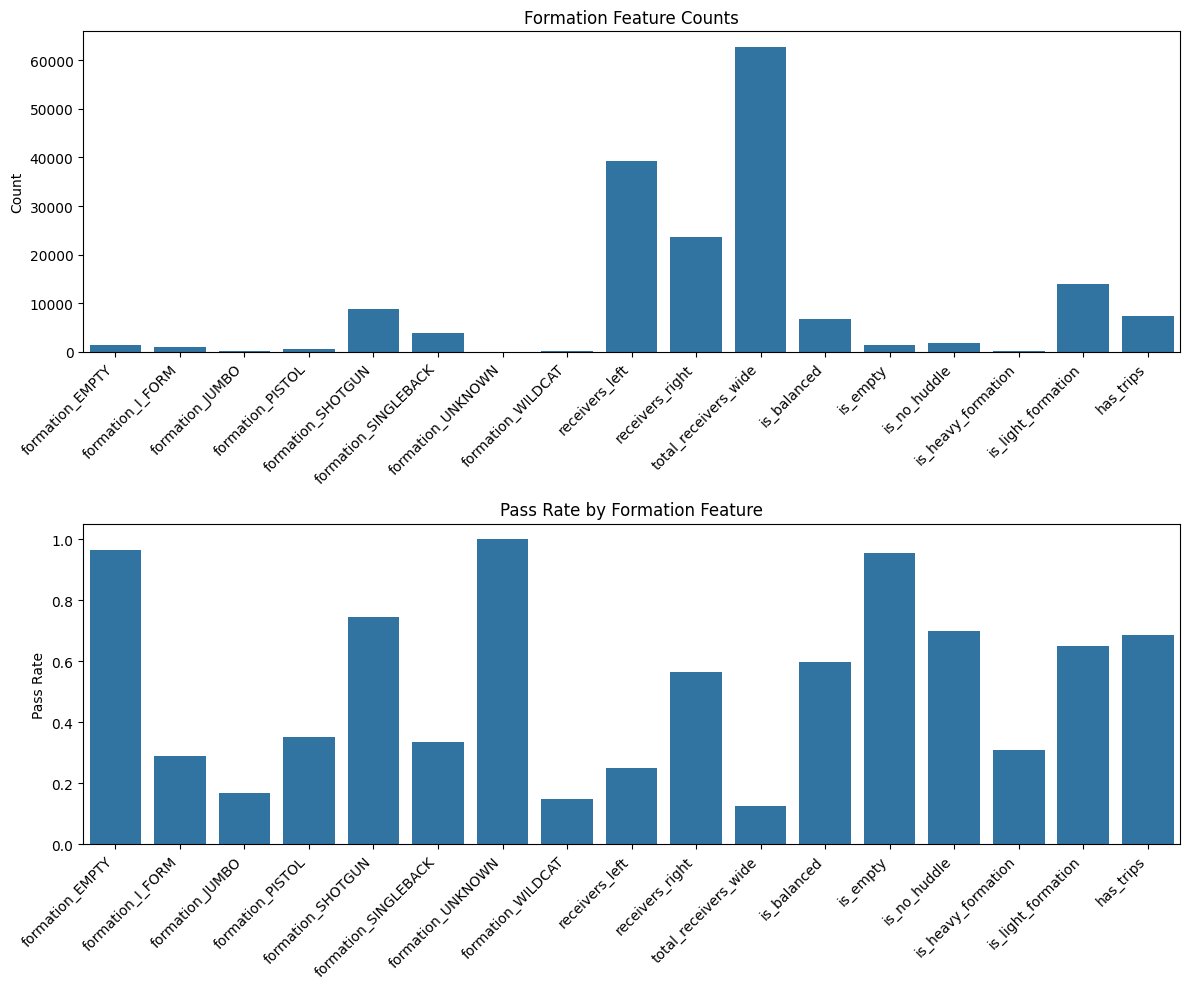

In [20]:
feature_names = []
counts = []
pass_rates = []

for col in formation_features:
    if df_with_formations[col].dtype in ['int64', 'float64', 'bool']:
        pass_rate = df_with_formations[df_with_formations[col] == 1]['is_pass'].mean()
        count = df_with_formations[col].sum()
        feature_names.append(col)
        counts.append(count)
        pass_rates.append(pass_rate)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot counts
sns.barplot(x=feature_names, y=counts, ax=ax1)
ax1.set_title('Formation Feature Counts')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylabel('Count')

# Plot pass rates
sns.barplot(x=feature_names, y=pass_rates, ax=ax2)
ax2.set_title('Pass Rate by Formation Feature')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylabel('Pass Rate')

plt.tight_layout()
plt.show()

## Historical Tendencies

Historical tendencies are created by calculating the average pass rate over the last 20 plays for each team, and the average pass rate for each down and distance combination. using the rolling mean and shift functions.

there is also a recent tendency feature which is the average pass rate over the last 3 plays for each team.

In [21]:
import numpy as np

def create_historical_tendencies(df):
    """
    Create basic historical tendency features using only prior information
    """
    feature_df = df.copy()
    feature_df = feature_df.sort_values(['gameId', 'playId'])
    
    # Overall team pass tendency (last 20 plays)
    feature_df['team_pass_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform(
        lambda x: x.rolling(window=20, min_periods=1).mean().shift(1).fillna(x.mean())
    )
    # Last 3 plays
    feature_df['recent_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean().shift(1).fillna(x.mean())
    )
    feature_df['team_overall_pass_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform('mean')
    feature_df['down_distance_pass_tendency'] = feature_df.groupby(['down_1', 'down_2', 'down_3', 'down_4', 'distance_short', 'distance_long'])['is_pass'].transform('mean')
    
    return feature_df

In [22]:
# Apply historical tendency features
df_with_tendencies = create_historical_tendencies(df_with_formations)

In [23]:
tendency_features = ['team_pass_tendency', 'recent_tendency', 'team_overall_pass_tendency', 'down_distance_pass_tendency']

# Check correlation with actual play calls
print("\nCorrelations with is_pass:")
correlations = df_with_tendencies[tendency_features].corrwith(df_with_tendencies['is_pass'])
print(correlations.sort_values(ascending=False))


Correlations with is_pass:
down_distance_pass_tendency    0.334682
team_overall_pass_tendency     0.131754
team_pass_tendency             0.120107
recent_tendency                0.093834
dtype: float64


In [24]:
def get_combined_features(df):
   # Formation interactions with down
   for down in [1,2,3,4]:
       df[f'formation_EMPTY_down_{down}'] = (df['formation_EMPTY'] == 1) & (df[f'down_{down}'] == 1)
       df[f'formation_SHOTGUN_down_{down}'] = (df['formation_SHOTGUN'] == 1) & (df[f'down_{down}'] == 1)
       
   # Receiver combinations
   df['receivers_ratio'] = df['total_receivers_wide'] / (df['receivers_left'] + df['receivers_right'] + 1)
   df['receiver_balance'] = abs(df['receivers_left'] - df['receivers_right'])
   
   # Distance and down interactions
   df['critical_distance'] = ((df['down_3'] == 1) | (df['down_4'] == 1)) & (df['yardsToGo'] <= 3)
   df['long_distance'] = df['yardsToGo'] > 10
   
   # Time pressure features
   df['end_quarter_pressure'] = (df['game_clock_seconds'] < 120) & ((df['quarter_2'] == 1) | (df['quarter_4'] == 1))
   
   # Formation complexity
   df['complex_formation'] = df['total_receivers_wide'] > 3
   
   return df

## Personnel Features

Personnel features are created by counting the number of players in each position group (RB, TE, WR, FB) and then calculating ratios and packages. They are encoded as binary indicators. 


In [25]:
def get_personnel_features(df, player_plays_df):
    # Create a copy of input dataframe
    personnel_features = df.copy()
    
    # Merge player positions from players.csv
    players_df = pd.read_csv('data/players.csv')
    player_plays_with_pos = player_plays_df.merge(players_df[['nflId', 'position']], 
                                                on='nflId', how='left')
    
    # Position counts per play
    position_counts = player_plays_with_pos.groupby(['gameId', 'playId', 'position']).size().unstack(fill_value=0)
    
    # Reset index to merge with main dataframe
    position_counts = position_counts.reset_index()
    
    # Merge position counts with main features
    personnel_features = personnel_features.merge(position_counts, on=['gameId', 'playId'], how='left')
    
    # Fill NaN values with 0 for position counts
    for pos in ['RB', 'TE', 'WR', 'FB']:
        if pos in personnel_features.columns:
            personnel_features[f'{pos}_count'] = personnel_features[pos].fillna(0)
        else:
            personnel_features[f'{pos}_count'] = 0
    
    # Calculate ratios and packages
    personnel_features['heavy_package'] = (personnel_features['TE_count'] + personnel_features['FB_count']) >= 2
    personnel_features['spread_formation'] = personnel_features['WR_count'] >= 3
    personnel_features['te_wr_ratio'] = personnel_features['TE_count'] / (personnel_features['WR_count'] + 1)
    
    # Situational features
    personnel_features['goal_line'] = personnel_features['absoluteYardlineNumber'] <= 5
    personnel_features['short_yardage'] = personnel_features['yardsToGo'] <= 3
    
    return personnel_features

## 1.7 Final Feature Set

The final feature set is created by combining all the relevant features into a single dataframe and then selecting the most important predictive features.

In [26]:
def prepare_final_features(df):
    """
    Combine all relevant features into final modeling dataset
    Keep only the most important predictive features
    """
    features_df = df.copy()
    
    # Apply combined features
    features_df = get_combined_features(features_df)
    
    # Apply personnel features
    features_df = get_personnel_features(features_df, player_play_df)
    
    # Basic features
    basic_features = [
        'down_1', 'down_2', 'down_3', 'down_4',
        'yardsToGo',
        'quarter_1',
        'quarter_2',
        'quarter_3',
        'quarter_4',
        'quarter_5',
    ]
    
    # Motion features  
    motion_features = [
        'has_motion', 'significant_movement', 'motion_level',
        'motion_frames', 'total_movement', 'motion_intensity'
    ]
    
    # Tendency features
    tendency_features = [
        'team_pass_tendency', 'recent_tendency',
        'team_overall_pass_tendency', 'down_distance_pass_tendency'
    ]
    
    # Situational features
    situational_features = [
        'distance_short', 'distance_long', 'is_third_and_long',
        'yards_to_goal', 'in_redzone', 'backed_up',
        'game_clock_seconds', 'end_of_half',
        'time_remaining_half', 'win_prob_differential', 
        'score_differential',
    ]
    
    # Combined features
    combined_features = [
        'formation_EMPTY_down_1', 'formation_EMPTY_down_2', 
        'formation_EMPTY_down_3', 'formation_EMPTY_down_4',
        'formation_SHOTGUN_down_1', 'formation_SHOTGUN_down_2',
        'formation_SHOTGUN_down_3', 'formation_SHOTGUN_down_4',
        'receivers_ratio', 'receiver_balance',
        'critical_distance', 'long_distance',
        'end_quarter_pressure', 'complex_formation'
    ]
    
    # Personnel features
    personnel_features = [
        'RB_count', 'TE_count', 'WR_count', 'FB_count',
        'heavy_package', 'spread_formation', 'te_wr_ratio',
        'goal_line', 'short_yardage'
    ]
    
    feature_columns = (basic_features + formation_features
        + tendency_features 
        + situational_features + combined_features
        + personnel_features)
    
    # final feature set
    X = features_df[feature_columns]
    y = features_df['is_pass']
    
    # check feature set
    print("Final feature set:")
    print(X.columns.tolist())
    print("\nFeature set shape:", X.shape)
    print("\nClass distribution:")
    print(y.value_counts(normalize=True))
    
    return X, y, features_df[feature_columns]

In [27]:
# Create final feature set
X, y, train_df = prepare_final_features(df_with_tendencies)

Final feature set:
['down_1', 'down_2', 'down_3', 'down_4', 'yardsToGo', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'quarter_5', 'formation_EMPTY', 'formation_I_FORM', 'formation_JUMBO', 'formation_PISTOL', 'formation_SHOTGUN', 'formation_SINGLEBACK', 'formation_UNKNOWN', 'formation_WILDCAT', 'receivers_left', 'receivers_right', 'total_receivers_wide', 'is_balanced', 'is_empty', 'is_no_huddle', 'is_heavy_formation', 'is_light_formation', 'has_trips', 'team_pass_tendency', 'recent_tendency', 'team_overall_pass_tendency', 'down_distance_pass_tendency', 'distance_short', 'distance_long', 'is_third_and_long', 'yards_to_goal', 'in_redzone', 'backed_up', 'game_clock_seconds', 'end_of_half', 'time_remaining_half', 'win_prob_differential', 'score_differential', 'formation_EMPTY_down_1', 'formation_EMPTY_down_2', 'formation_EMPTY_down_3', 'formation_EMPTY_down_4', 'formation_SHOTGUN_down_1', 'formation_SHOTGUN_down_2', 'formation_SHOTGUN_down_3', 'formation_SHOTGUN_down_4', 'receivers_

## Plotting Feature Correlations

This plot shows the correlation between each feature and the target variable (pass or run).
Positive correlations indicate that the feature is more likely to be associated with a pass play, 
while negative correlations suggest the opposite.


c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


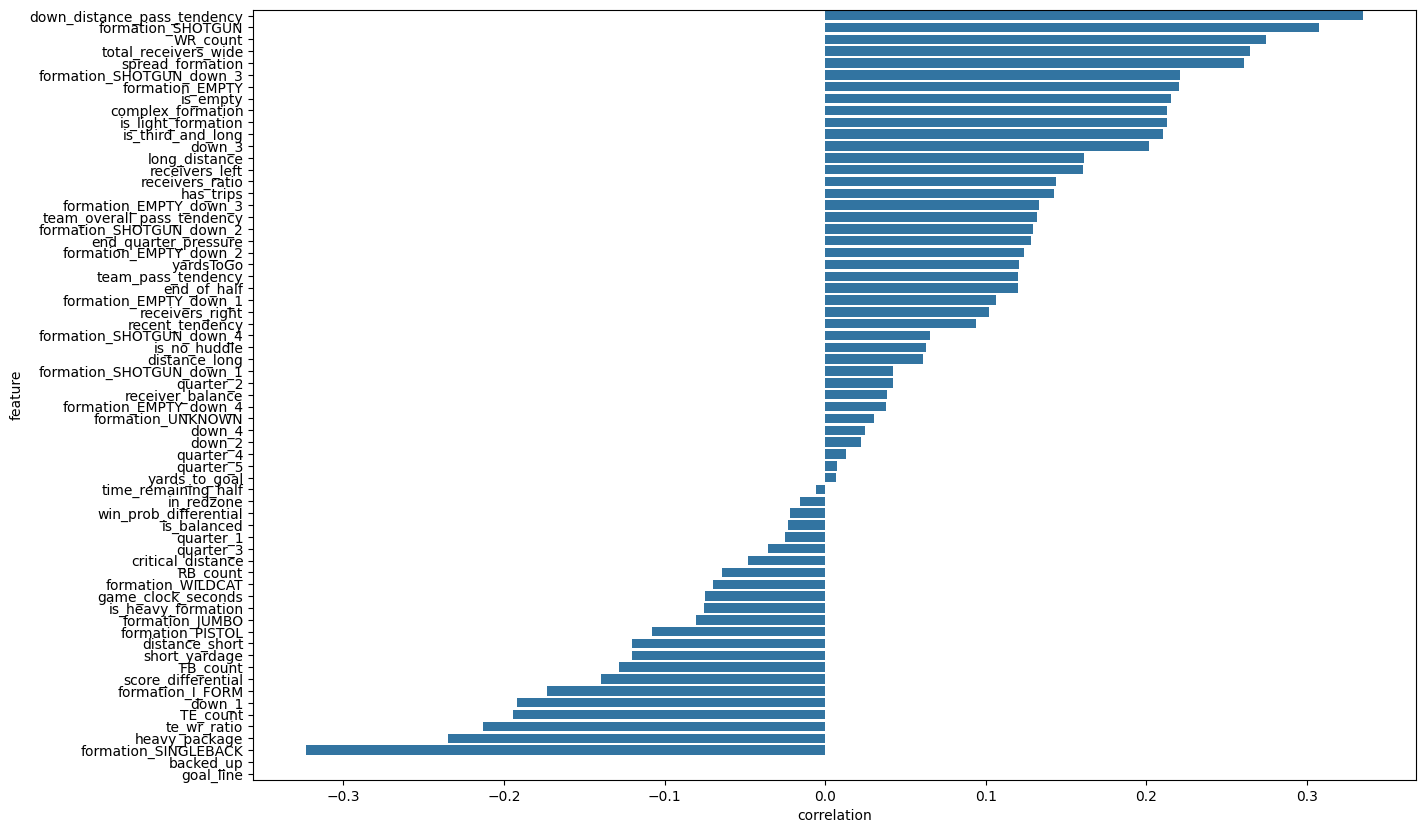

In [28]:
# Quick look at feature correlations with target
correlations = pd.DataFrame({
    'feature': X.columns,
    'correlation': X.corrwith(y)
}).sort_values('correlation', ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot(x='correlation', y='feature', data=correlations, orient='h')
plt.show()

### Feature importance

This visualization shows feature correlations in the engineered features. A few noteable positive features are down_distance_pass_tendency which has the strongest positive correlation (~0.3)
WR_count and total_receivers_wide are also highly positively correlated, spread_formation and formation_SHOTGUN_down_3 show significant positive correlations. For the negative correlated features, goal_line shows the strongest negative correlation (~-0.35) backed_up and formation_SINGLEBACK have strong negative correlations, heavy_package follows as another significant negative indicator. 

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
class PlayPredictionDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features).to(device)
        self.targets = torch.FloatTensor(targets.values).to(device)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [31]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42
)

# Then split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,  
    random_state=42
)

# Scale features using only training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create datasets
train_dataset = PlayPredictionDataset(X_train_scaled, y_train)
val_dataset = PlayPredictionDataset(X_val_scaled, y_val)
test_dataset = PlayPredictionDataset(X_test_scaled, y_test)

## 1.8 Model Architecture 

The model architecture is a combination of a convolutional neural network (CNN) and a feature group processing layer. The CNN is used to process the raw numerical features, while the feature group processing layer is used to process the categorical features. The output of the CNN is then combined with the output of the feature group processing layer and passed through a series of fully connected layers to produce the final classification output.


In [32]:
import torch
import torch.nn as nn

class PlayCNN(nn.Module):
    def __init__(self, num_features=X_train.shape[1]):
        super(PlayCNN, self).__init__()
        self.num_features = num_features
        
        # Feature group processing
        self.feature_groups = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.4)
        )
        
        # Convolutional blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                     out_channels=32, 
                     kernel_size=(3,1),
                     padding=(1,0)), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # flattened size
        self.flat_features = 32 * num_features * 1
        
        # Classification head combining conv and feature group outputs
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_features + 32, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )
        
    def forward(self, x):
        # Process feature groups
        feature_groups = self.feature_groups(x)
        
        # CNN processing
        x_conv = x.view(-1, 1, self.num_features, 1)
        x_conv = self.conv_block1(x_conv)
        x_conv = x_conv.view(-1, self.flat_features)
        
        # Combine feature groups with CNN output
        combined = torch.cat((x_conv, feature_groups), dim=1)
        
        # Final classification
        x = self.classifier(combined)
        return x

### Model Architecture

The model I implemented employs a hybrid architecture that combines neural network components with convolutional processing. It processes input features through two parallel paths:

1. A feature group pathway that uses dense layers with batch normalization and dropout
2. A convolutional pathway that processes the reshaped input through 2D convolutions

The use of parallel processing paths is because some features are more meaningful when processed together. The goal of this hybrid approach is for the CNN pathway to capture formation-based patterns (shown as important in SHAP values later) and the dense feature pathway can process situational features (down, distance, tendencies) This combination allows the model to weigh both structural and situational factors in its predictions

In [33]:
# Calculate class weights
n_runs = (y_train == 0).sum()
n_passes = (y_train == 1).sum()

weight_multiplier = 1.45
pos_weight = torch.tensor([n_runs / n_passes * weight_multiplier]).to(device)

print(f"Original weight would be: {n_runs / n_passes:.3f}")
print(f"Adjusted weight: {pos_weight.item():.3f}")

Original weight would be: 0.643
Adjusted weight: 0.932


In [34]:

model = PlayCNN(num_features=X_train_scaled.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

# Learning rate scheduler - reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-6
)

c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [35]:
num_epochs = 50
avg_losses = []
val_losses = []
max_grad_norm = 0.4

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Validation 
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features)
            val_loss = criterion(outputs, targets.unsqueeze(1))
            total_val_loss += val_loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Step scheduler based on val loss
    scheduler.step(avg_val_loss)
    
    avg_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

Epoch [1/50] Train Loss: 0.5415, Val Loss: 0.5096
Epoch [2/50] Train Loss: 0.5057, Val Loss: 0.5007
Epoch [3/50] Train Loss: 0.4970, Val Loss: 0.4961
Epoch [4/50] Train Loss: 0.4935, Val Loss: 0.4940
Epoch [5/50] Train Loss: 0.4905, Val Loss: 0.4949
Epoch [6/50] Train Loss: 0.4891, Val Loss: 0.4946
Epoch [7/50] Train Loss: 0.4839, Val Loss: 0.4941
Epoch [8/50] Train Loss: 0.4819, Val Loss: 0.4964
Epoch [9/50] Train Loss: 0.4814, Val Loss: 0.4937
Epoch [10/50] Train Loss: 0.4813, Val Loss: 0.4925
Epoch [11/50] Train Loss: 0.4832, Val Loss: 0.4917
Epoch [12/50] Train Loss: 0.4802, Val Loss: 0.4913
Epoch [13/50] Train Loss: 0.4821, Val Loss: 0.4915
Epoch [14/50] Train Loss: 0.4797, Val Loss: 0.4912
Epoch [15/50] Train Loss: 0.4807, Val Loss: 0.4907
Epoch [16/50] Train Loss: 0.4799, Val Loss: 0.4910
Epoch [17/50] Train Loss: 0.4813, Val Loss: 0.4900
Epoch [18/50] Train Loss: 0.4796, Val Loss: 0.4896
Epoch [19/50] Train Loss: 0.4788, Val Loss: 0.4891
Epoch [20/50] Train Loss: 0.4790, Val Lo

In [36]:
def predict(model, scaler, features):
    features_scaled = scaler.transform(features)
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(features_tensor).to(device)
        probabilities = torch.sigmoid(logits)
    
    return probabilities.cpu().numpy()

# Example prediction
sample_play = X.iloc[[0]]  
print(sample_play)
pred = predict(model, scaler, sample_play)
print(f"Probability of pass: {pred[0][0]:.3f}")

   down_1  down_2  down_3  down_4  yardsToGo  quarter_1  quarter_2  quarter_3  \
0    True   False   False   False         10       True      False      False   

   quarter_4  quarter_5  ...  complex_formation  RB_count  TE_count  WR_count  \
0      False      False  ...               True         1         1         3   

   FB_count  heavy_package  spread_formation  te_wr_ratio  goal_line  \
0         0          False              True         0.25      False   

   short_yardage  
0          False  

[1 rows x 65 columns]
Probability of pass: 0.566


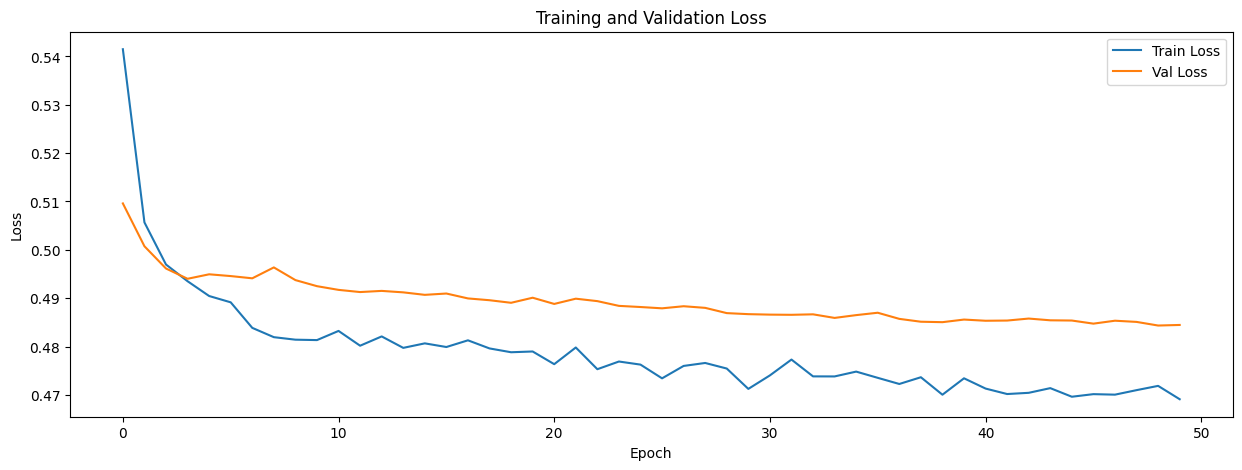

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(avg_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Keep Track of evaluation metrics

Save eval metrics to a csv.

In [38]:
# Example prediction
# 10 is a pass play
sample_play = X.iloc[[10]]
pred = predict(model, scaler, sample_play)
print(f"play: {sample_play}")
print(f"Probability of pass: {pred[0][0]:.3f}")

play:     down_1  down_2  down_3  down_4  yardsToGo  quarter_1  quarter_2  \
10   False   False    True   False          8       True      False   

    quarter_3  quarter_4  quarter_5  ...  complex_formation  RB_count  \
10      False      False      False  ...               True         1   

    TE_count  WR_count  FB_count  heavy_package  spread_formation  \
10         1         3         0          False              True   

    te_wr_ratio  goal_line  short_yardage  
10         0.25      False          False  

[1 rows x 65 columns]
Probability of pass: 0.927


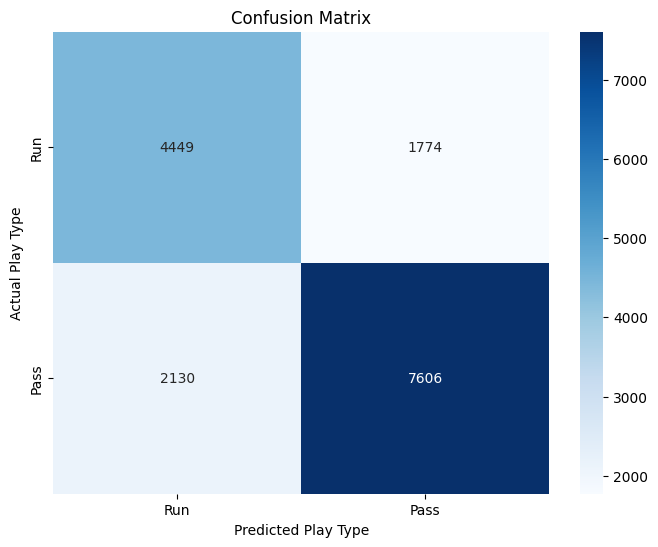

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_proba = predict(model, scaler, X)[:, 0]
y_true = y.values 

y_pred = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Play Type')
plt.xlabel('Predicted Play Type')

# Add custom labels
tick_labels = ['Run', 'Pass']
plt.gca().set_xticklabels(tick_labels)
plt.gca().set_yticklabels(tick_labels)

plt.show()

Average Precision Score: 0.893


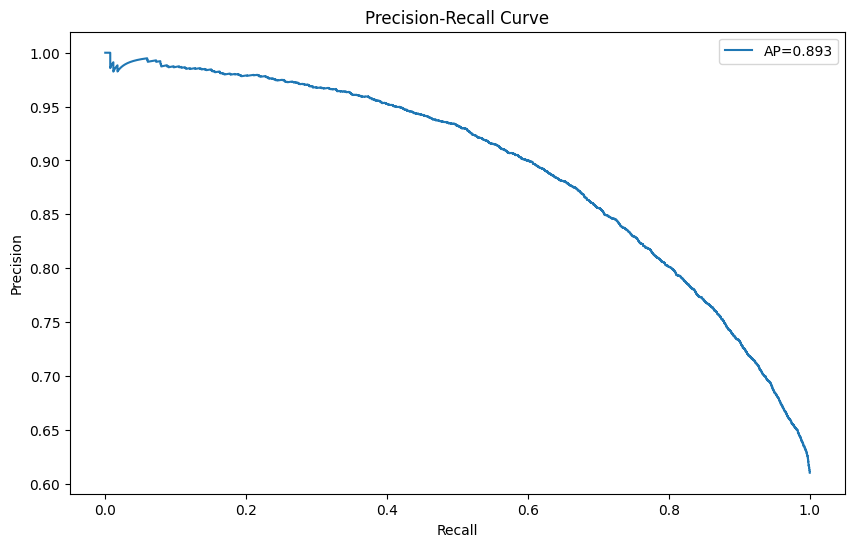

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate various metrics
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)

print(f"Average Precision Score: {ap:.3f}")

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.70      6223
           1       0.81      0.78      0.80      9736

    accuracy                           0.76     15959
   macro avg       0.74      0.75      0.75     15959
weighted avg       0.76      0.76      0.76     15959



In [42]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc

# Create test loader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Evaluate on test set
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        probs = torch.sigmoid(outputs)
        test_predictions.extend(probs.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

# Calculate metrics on test set
test_preds_binary = (test_predictions > 0.5).astype(int)

print("\nTest Set Metrics:")
print(classification_report(test_targets, test_preds_binary))


Test Set Metrics:
              precision    recall  f1-score   support

         0.0       0.66      0.70      0.68      1264
         1.0       0.80      0.77      0.78      1928

    accuracy                           0.74      3192
   macro avg       0.73      0.73      0.73      3192
weighted avg       0.74      0.74      0.74      3192



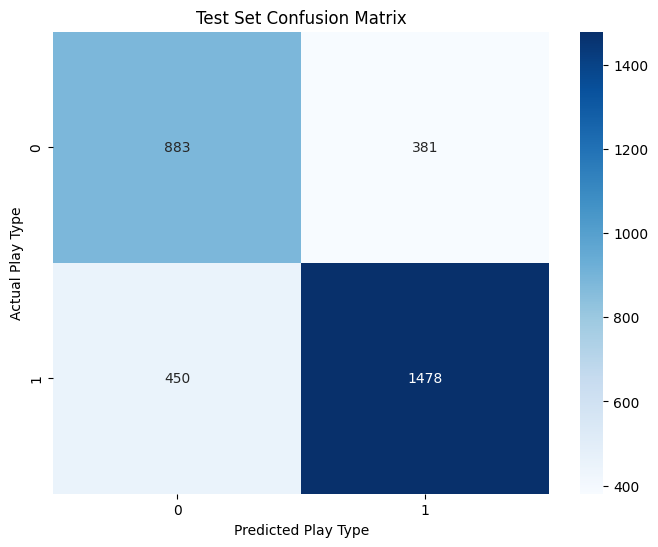

In [43]:
# Plot confusion matrix for test set
cm_test = confusion_matrix(test_targets, test_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.ylabel('Actual Play Type')
plt.xlabel('Predicted Play Type')
plt.show()

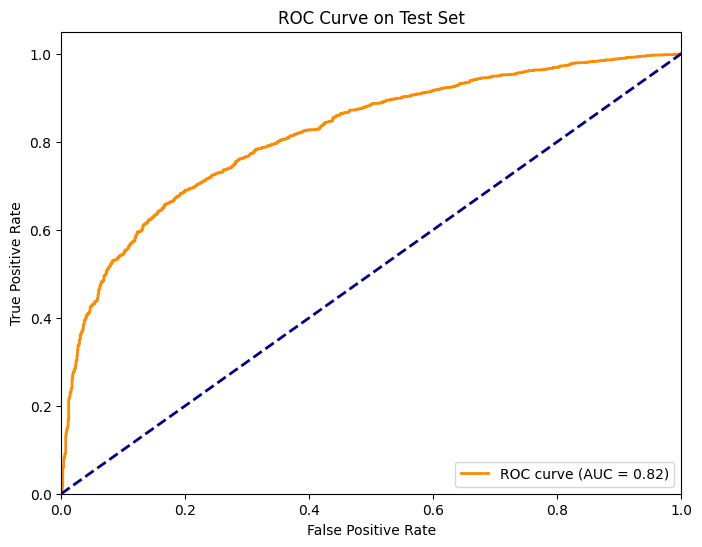

In [44]:
# Calculate and plot ROC curve for test set
fpr, tpr, _ = roc_curve(test_targets, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.show()

In [83]:
import shap
model.eval()

# Create background dataset from training data
background = torch.FloatTensor(scaler.transform(X[:1000])).to(device)
test_targets = torch.FloatTensor(scaler.transform(X[:1000])).to(device)

# Create explainer using background data
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_targets, check_additivity=False)

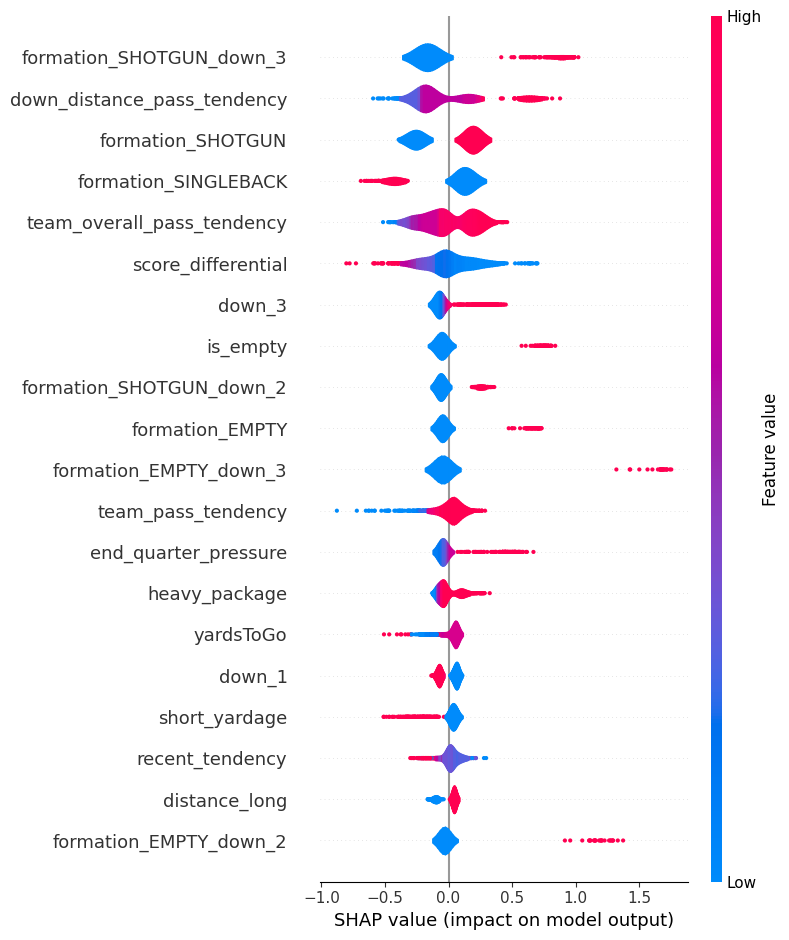

In [84]:
# Create plots
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values.squeeze(), test_targets.cpu().numpy(), 
                  feature_names=X.columns.tolist(), plot_type='violin')

### Shapely feature impact

Formations Impact (SHOTGUN, SINGLEBACK, EMPTY) have significant but varying impacts on the model's predictions, SHOTGUN formations in different downs (down_2, down_3) show notable influence. The formation impacts are context-dependent, varying based on the down situation


For Passing Tendencies team_overall_pass_tendency has one of the strongest positive impacts and down_distance_pass_tendency shows a mixed effect, with both positive and negative influences depending on context


With Situational Factors down_3 appears as a significant negative factor, score_differential shows a wide distribution of impacts whereas yardage-related features (yardsToGo, short_yardage, distance_long) have varied effects

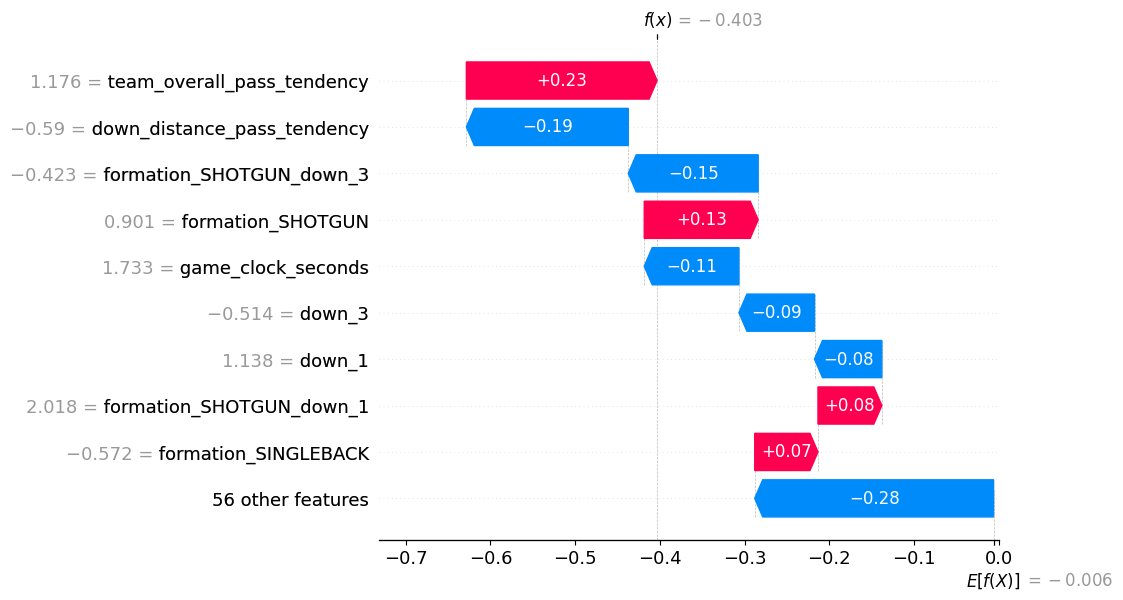

In [85]:
# Calculate base value and get first few predictions
base_value = shap_values[0].mean()
shap_values_few = shap_values[0][:1]  

e = shap.Explainer(model, shap_values.squeeze())

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values.squeeze()[0],
        base_values=base_value,
        data=test_targets[0].cpu().numpy(),
        feature_names=X.columns.tolist()
    ),
    show=False
)
plt.show()


#### Final Thoughts

An overall accuracy of 75% is decent, Although football is unpredictable, and this task is difficult I feel as though in the future I will be able to improve it, I did a PCA dimensionality reduction and with the current features I would only need 22 to cover 80% of the variance. So, in the future I will be removing some features that may be causing noise. select 22 of the most importatnt features and see how that works. Furthermore maybe attempting a different model architecture although this has been one of the best performing models.